## Plot 11 LMEs over the North American

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm,colors,rc
import os

In [2]:
USER = os.environ['USER']

In [3]:
# spatial ranges
lat_min = 15;   lat_max = 65
lon_min = -190; lon_max = -40
lat_range = [lat_min,lat_max]
lon_range = [lon_min,lon_max]
# spatial indices
a1,a2,b1,b2 = [240,380,125,320]

In [4]:
# Etopo data
path = f'/glade/work/{USER}/MAPP/ETOPO'
filename = f'{path}/Etopo1_Bed_0_65N_170E_40W.nc'
bathy = xr.open_dataset(filename)
lon_e = bathy['lon']
for ii in range(len(lon_e)):
    if lon_e[ii]>0:
        lon_e[ii] = lon_e[ii] - 360.
lat_e = bathy['lat'][300:]
depth_e = bathy['depth'][300:,:]
bathy.close()
#
mask_bathy = (depth_e >= 0.)*1.
mask_bathy = np.ma.array(mask_bathy,mask=mask_bathy==0.)
lon_e,lat_e = np.meshgrid(lon_e,lat_e)
lon_e = np.ma.array(lon_e,mask=~mask_bathy.mask)
lat_e = np.ma.array(lat_e,mask=~mask_bathy.mask)
depth_e1 = -np.ma.array(depth_e,mask=~mask_bathy.mask)

In [5]:
# LME data
datadir = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME-mask-POP_gx1v6.nc' % datadir
ds = xr.open_dataset(filename)
lme_mask = ds['lme_mask'][a1:a2,b1:b2]
lon = ds['TLONG'].values[a1:a2,b1:b2]-360.
lat = ds['TLAT'].values[a1:a2,b1:b2]
ds.close()

In [6]:
boxn = [1,2,3,4,5,6,7,8,9,10,65]
for x1 in range(a2-a1):
    for y1 in range(b2-b1):
        if np.isnan(lme_mask[x1,y1])==False:
            if lme_mask[x1,y1] not in boxn:
                lme_mask[x1,y1] = float("nan")
            elif lme_mask[x1,y1] == 65:
                lme_mask[x1,y1] = 11

In [7]:
# print number of grid points within each LME
for bb in range(1,12,1):
    print('box',bb,np.sum(lme_mask==bb).values)

box 1 261
box 2 316
box 3 378
box 4 26
box 5 270
box 6 61
box 7 62
box 8 68
box 9 263
box 10 163
box 11 35


In [8]:
# LME boundaries
path = f'/glade/u/home/{USER}/O2prediction/Prediction/notebooks/data'
filename = '%s/LME_shapes.gmt' % path
file1 = open(filename,'r')
lines = file1.readlines()
#
nbox = -1
lonn = [[] for ii in range(194)]
latt = [[] for ii in range(194)]
ln = 9
for line in lines[ln:]:
    sl = line.split()
    if len(sl)==2 and sl[0] == '#':
        nbox = nbox + 1
    elif len(sl)==2 and sl[0] != '#':
        lonn[nbox-1].append(float(sl[0]))
        latt[nbox-1].append(float(sl[1]))
##
pp180 = []
for pp in range(len(lonn)):
    if len(lonn[pp])>0:
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        if len(np.where(np.abs(lon1 + 180.)<1e-4)[0])>0:
            if len(lonn[pp])<4:
                pp180.append(pp)
##
lon0 = []
lat0 = []
nn = 0
for pp in range(len(lonn)):
    if len(lonn[pp])!=0:
        nn = nn + 1
        if np.min(lonn[pp])>0:
            lon1 = np.array(lonn[pp]) - 360.
        else:
            lon1 = np.array(lonn[pp])
        lat1 = np.array(latt[pp])
        lon1 = np.ma.array(lon1,mask=False)
        lat1 = np.ma.array(lat1,mask=False)
        if pp in pp180[1:]:
#        if len(np.where(np.abs(lon1+180.)<1e-4)[0]) > 0:
            #print(pp)
            aa = np.where(np.abs(lon1+180.)<1e-4)[0]
            lon1.mask[aa] = True
            lat1.mask[aa] = True
        lon0.append(lon1)
        lat0.append(lat1)

/glade/u/home/czhuomin/.conda/envs/fish-offline/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
/glade/u/home/czhuomin/.conda/envs/fish-offline/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.


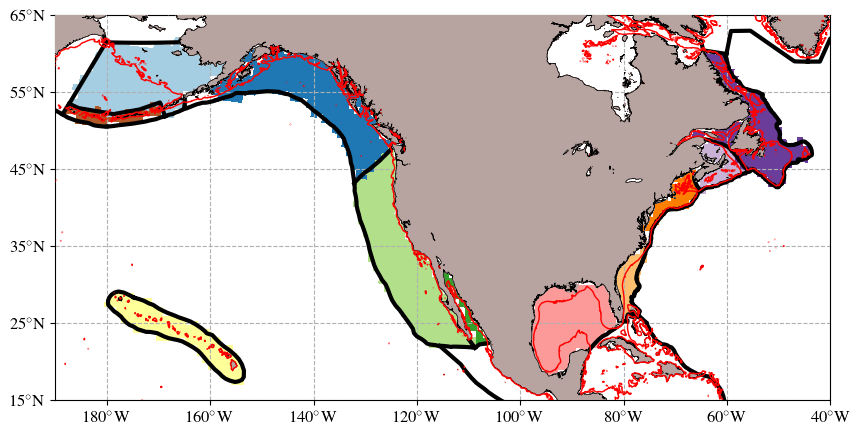

In [9]:
vcs = np.array([0,1000,2000,3000,4000,5000,6000,7000])
vcs = -vcs[::-1]
pal_norm = colors.BoundaryNorm(vcs,ncolors=256, clip = False)
#
col = ['violet','magenta','purple','navy',\
       'blue','skyblue','green','yellowgreen',\
       'yellow','orange','tomato','darkred']
boxn = [1,2,3,4,5,6,7,8,9,10,11]
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
#
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
# plot LME boundaries
for pp in range(len(lon0)):
    ax.plot(lon0[pp],lat0[pp],color='k',linewidth=3.,zorder=19)
# plot LMEs
plt.pcolor(lon, lat, lme_mask, cmap=cm.Paired)
# plot continent/bathymetry
ax.pcolor(lon_e,lat_e,mask_bathy,shading='nearest',cmap=cm.terrain_r,vmin=.5,vmax=4,zorder=20)
# plot coastal lines
ax.contour(lon_e,lat_e,depth_e,[0],colors='k',linestyles='solid',linewidths=.5,zorder=21)
# plot 200-m isobaths
ax.contour(lon_e,lat_e,depth_e,[-200],colors='r',linestyles='solid',linewidths=1.,zorder=21)
#
ax.set_xlim(lon_min,lon_max)
ax.set_ylim(lat_min,lat_max)
ax.set_xticks(np.arange(-180,-30,20))
ax.set_yticks(np.arange(15,66,10))
#
xtl = []
for ii in np.arange(-180,-30,20):
    if ii < -180:
        ii = ii + 360
        ff = 'E'
    elif ii >= -180:
        ff = 'W'
    elif np.abs(ii-0)<1e-5:
        ff = ''
    xtl.append('%d$^\circ$%s' % (abs(ii),ff))
ytl = []
for jj in np.arange(15,66,10):
    if jj < 0:
        ff = 'S'
    elif jj > 0:
        ff = 'N'
    elif np.abs(jj-0)<1e-5:
        ff = ''
    ytl.append('%d$^\circ$%s' % (abs(jj),ff))
ax.set_xticklabels(xtl,fontsize=12,fontweight='bold')
ax.set_yticklabels(ytl,fontsize=12,fontweight='bold')
ax.grid(linestyle='dashed')
# save figure
output=f'/glade/scratch/{USER}/DPLE-plots'
outfile=f'{output}/Figure1_map_LME_box01-11_and_bathymetry_north_america.png'
plt.savefig(outfile,dpi=400)
plt.show()